# 正则化逻辑回归

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告
from util import *

C:\Users\Alex\Anaconda3\envs\MachineLearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('ex2data2.txt', names=['x1', 'x2', 'y'])
df.head()

,x1,x2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


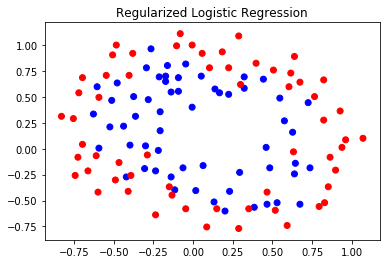

In [3]:
color = list(map(lambda x: 'red' if x==0 else 'blue', df.y))
plt.scatter(df.x1, df.x2, c=color)
plt.title('Regularized Logistic Regression')
plt.show()

### 多项式特征映射

将两个特征映射到 n 次多项式特征上

In [4]:
def feature_mapping(x1, x2, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)

    data = {"f{}{}".format(i - p, p): np.power(x1, i - p) * np.power(x2, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).values
    else:
        return pd.DataFrame(data)


In [5]:
data = feature_mapping(df.x1, df.x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


## regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [6]:
def regularized_cost(theta, X, y, lam=1):
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (lam / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term

## regularized gradient(正则化梯度)

$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }\text{   for  j}\ge \text{1}$$

$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)\text{ }\text{   for  j}=\text{0}$$

In [7]:
def regularized_gradient(theta, X, y, lam=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (lam / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

## 拟合参数

In [8]:
theta = np.zeros(data.shape[1])
theta = np.zeros(data.shape[1])
X = feature_mapping(df.x1, df.x2, power=6, as_ndarray=True)
y = get_y(df)

res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)

### 画出决策边界

In [9]:
def draw_decision_boundary(df, power, lam=0, density=200, threshhold=4e-2, alpha=0.05):
    """
    Draw decision boundary for 2D polynomial logistic regression 
    
    Assume that df data format is ['x1', 'x2', 'y'] 
    """
    
    # draw normalized data
    df = normalize_feature(df)
    df.y = y
    color = list(map(lambda x: 'red' if x==0 else 'blue', df.y))
    plt.scatter(df.x1, df.x2, c=color)
    
    # trainning data
    X = feature_mapping(df.x1, df.x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])
    res = opt.minimize(fun=regularized_cost, x0=theta,args=(X, y, lam), method='TNC', jac=regularized_gradient)
    final_theta = res.x
    
    # find decision boundary
    t1 = np.linspace(-2., 2., density)
    t2 = np.linspace(-2., 2., density)
    x1_cord, x2_cord = np.meshgrid(t1, t2)
    x1_cord, x2_cord = x1_cord.flatten(), x2_cord.flatten()
    X_cord = feature_mapping(x1_cord, x2_cord, power, as_ndarray=True)
    inner_product = X_cord @ final_theta
    # draw decision boundary
    boundary = X_cord[np.abs(sigmoid(inner_product) - 0.5) < threshhold]
    plt.scatter(X_cord[:,1], X_cord[:,2], c=sigmoid(inner_product), s=1, alpha=alpha)
    plt.scatter(boundary[:,1], boundary[:,2], c='green', s=1)
    plt.title('Decision boundary')
    plt.show()
    return X, final_theta

使用 4 次多项式, 不使用正则化

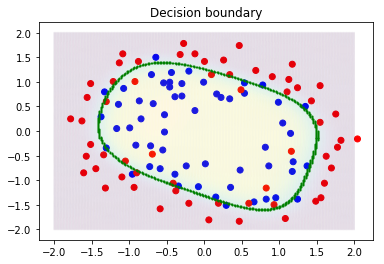

             precision    recall  f1-score   support

          0       0.88      0.82      0.84        60
          1       0.82      0.88      0.85        58

avg / total       0.85      0.85      0.85       118



In [10]:
X, final_theta = draw_decision_boundary(df, 4)
y_pred = predict(X, final_theta)
print(classification_report(y, y_pred))

使用 7 次多项式, 不使用正则化. 图像形状复杂, 可能是过拟合了

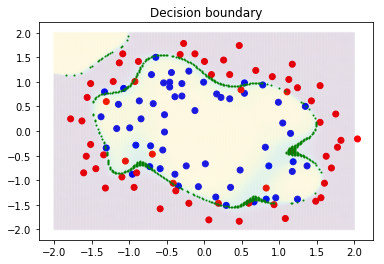

             precision    recall  f1-score   support

          0       0.91      0.87      0.89        60
          1       0.87      0.91      0.89        58

avg / total       0.89      0.89      0.89       118



In [11]:
X, final_theta = draw_decision_boundary(df, 7)
y_pred = predict(X, final_theta)
print(classification_report(y, y_pred))

使用 7 次多项式, 正则化参数为 1.5

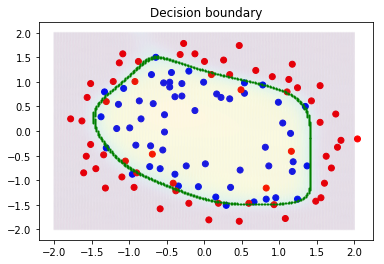

             precision    recall  f1-score   support

          0       0.89      0.83      0.86        60
          1       0.84      0.90      0.87        58

avg / total       0.87      0.86      0.86       118



In [12]:
X, final_theta = draw_decision_boundary(df, 7,  lam=1.5)
y_pred = predict(X, final_theta)
print(classification_report(y, y_pred))